In [46]:
import pandas as pd
import numpy as np
from torch import nn
from sklearn.preprocessing import PowerTransformer
from torchviz import make_dot
from itertools import islice
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import statistics as stats
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import hiddenlayer as hl
import graphviz

In [47]:
g = graphviz.Graph(engine='neato')

# Importing the data

In [48]:
def to_list(str):
    '''
    :param str: string representing a list of centipawn losses
    :return: list of integer centipawn losses
    '''
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    list = [int(i) for i in ls]

    return list

In [49]:
def process(eval):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    # starting evaluation of 30 centipawns
    sum = 30

    i = 0
    res = []

    # iterating through centipawn losses
    for cpl in eval:

        # subtracting the cpl for white's moves
        if i % 2 ==0:
            res.append([sum,cpl])
            sum -= cpl
            i += 1

        # adding the cpl for black's moves
        else:
            sum+=cpl
            i+=1

    return np.array(res)

In [50]:
# reading *some* of the data
dfs = []

players = ['andreikin, dmitry', 'anand, viswanathan', 'wang, hao', 'grischuk, alexander', 'karjakin, sergey','duda, jan-krzysztof', 'radjabov, teimour', 'dominguez perez, leinier','nakamura, hikaru', 'vachier-lagrave, maxime','aronian, levon','mamedyarov, shakhriyar', 'so, wesley','ding, liren', 'rapport, richard', 'nepomniachtchi, ian', 'giri, anish', 'firouzja, alireza', 'caruana, fabiano','carlsen, magnus','zelcic, robert','khotenashvili, bela', 'bischoff, klaus', 'hoffmann, asa','kaufman, lawrence','bellaiche, elise']

# reading the csvs
for player in players:
    df = pd.read_csv('blitz/'+player +'.csv')
    dfs.append(df)
df = pd.concat(dfs)


print(f"Total  games: {len(df)}")

# Filtering out * values
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

df = df[df['Eval'] != '']
df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]


# converting the evaluation to a list
df['Eval'] = df['Eval'].apply( to_list)
df['Eval'] = df['Eval'].apply( process )

print(f"Evaluted games: {len(df['Eval'])}")

Total  games: 4210
Evaluted games: 434


In [51]:
x = np.array(df['Eval'])
length = np.array(df['Eval'].apply(len))

In [52]:
# creating and fitting a power transformer
pt = PowerTransformer()
y = np.concatenate(x)
pt.fit(y)
transformed = pt.transform(y)

In [53]:
# need a function now to (effieciently) change these to lists of length list
transformed_array = [np.array(list(islice(iter(transformed), elem)))
        for elem in length]

In [54]:
print(f"Unique evaluated games: {df['Game'].nunique()}")

Unique evaluated games: 422


# Preparing the data for the Neural Net

In [55]:
# converting evaluations and length to tensors
evals = [torch.tensor(i, dtype = torch.float32) for i in transformed_array]
lengths = [len(tensor) for tensor in evals]

In [56]:
# Padding my sequences - not sure why batch first works, but it does
#inputs = torch.nn.utils.rnn.pad_sequence(evals, batch_first=True, padding_value=0.0)

In [57]:
#inputs_array = np.array(inputs.tolist())

In [58]:
#print(inputs.shape)

In [59]:
#inputs_list =inputs.tolist()

# normalizing... a bit hacky
#inputs_array = (np.array(inputs_list) - np.array(inputs_list).mean())/ np.linalg.norm(np.array(inputs_list))

In [60]:
def normalize(array):
    '''
    :param array:
    :return:
    '''
    return (array - array.mean())/array.std()

def denormalize(array, value):
    '''
    :param array:
    :param value:
    :return:
    '''
    return value*array.std() + array.mean()

In [61]:
#print(df['WhiteELO'].value_counts())

In [62]:
# Converting White and Black's ELOs to tensors
white_elo_arr = np.array(df['WhiteELO'])

white_elo = normalize(white_elo_arr)

#print(white_elo)
white_elo = [torch.tensor(i, dtype = torch.float32) for i in white_elo]



black_elo = np.array(df['BlackELO'])
black_elo = [torch.tensor(i, dtype = torch.float32) for i in black_elo]


# splitting into train and test
lengths_train, lengths_test,eval_train, eval_test, black_train, black_test, white_train, white_test  = train_test_split(lengths, evals, black_elo, white_elo, test_size=0.2,random_state=0, shuffle = True)


In [63]:
# zipping the elo together with the evaluations
train_data_zip = list(zip(eval_train, white_train))
test_data_zip = list(zip(eval_test, white_test))

In [64]:
black_elo = torch.stack(black_elo)
white_elo = torch.stack(white_elo)

# Creating the Neural Net

In [65]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        self.rnn = nn.RNN(input_size, hidden_size, no_layers, batch_first = True, bias = True)
        self.fc = nn.Linear(hidden_size,1, bias = False)
        self.final = nn.Tanh()

    def forward(self, x):

        out, _ = self.rnn(x)


        # shape batches, seq_length, hidden_size
        with torch.no_grad():
            output ,lengths = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first = True)
            out = [output[e, i-1,:].unsqueeze(0)for e, i in enumerate(lengths)]
            out = torch.cat(out, dim = 0)
        #print(out.shape)
        #print("Linear weights", self.fc.weight)
        out = self.fc(out)
        out = self.final(out)
        #print(out.shape)
        out = out[:,0]
        return out


    #def init_hidden(self):
    #    return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

# need to figure out exactly how the dimensions changed


In [66]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    # remove that eventually. I'm going to need to make my dataset a tuple with evals and elo
    #def __init__(self):

    def __call__(self, batch):
        data = [item[0] for item in batch]
        target = [item[1] for item in batch]
        lens = [i.shape[0] for i in data]

        #print(lens)
        data = torch.nn.utils.rnn.pad_sequence(data, batch_first=True,padding_value = 0)
        #data = data.unsqueeze(2)
        #print("PADDED",data)
        evals_packed = torch.nn.utils.rnn.pack_padded_sequence(data,batch_first = True, lengths=lens,enforce_sorted=False)

        target = torch.tensor(target,dtype=torch.float32)
        return [evals_packed,target]

In [67]:
input_size = 2
hidden_size = 1
no_layers = 2
batch_size = 5

In [68]:
# (defining my model)
model = MyRNN(input_size, hidden_size, no_layers)
collate = MyCollator()

In [69]:
# for name, param in model.named_parameters():
#     print('name: ', name)
#     print(type(param))
#     print('param.shape: ', param.shape)
#     print('param.requires_grad: ', param.requires_grad)
#     print('=====')

In [70]:
#eval_train = [torch.tensor(i, dtype = torch.float32) for i in eval_train]
#white_train = [torch.tensor(i, dtype = torch.float32) for i in white_train]

#eval_train = torch.stack(eval_train)
#white_train = torch.stack(white_train)

#train_data = list(zip(evals_packed, white_train))


#eval_test = [torch.tensor(i, dtype=torch.float32) for i in eval_test]
#white_test = [torch.tensor(i, dtype=torch.float32) for i in white_test]

#eval_test = torch.stack(eval_test)
#white_test = torch.stack(white_test)


# not sure why I'm seeing a warning...

In [71]:
print(model.parameters)

<bound method Module.parameters of MyRNN(
  (rnn): RNN(2, 1, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1, out_features=1, bias=False)
  (final): Tanh()
)>


# Training the model

In [72]:
data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True ,collate_fn=collate)

In [73]:
learning_rate = .2

In [74]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [75]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [76]:
# OK I've figured out the issue, I also need the sequence length for the RNN

In [77]:
avg_losses = []
epochs = []
avg_loss = 1

for epoch in range(1):

    if (epoch+1) % 10 ==0:
        learning_rate /= 2
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    i = 0
    losses = []
    for evals, elo in data_loader:
        evals = evals.to(device)

        elo = elo.to(device)
        i +=1
        outputs = model(evals)
        #print(outputs)
        #print(outputs.shape, elo.shape)
        loss = criterion(outputs,elo)
        # optimizing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    change = stats.mean(losses)/avg_loss
    avg_loss = stats.mean(losses)
    avg_losses.append(avg_loss)
    epochs.append(epoch)
    print(f'Epoch {epoch+1} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {avg_loss:3f} - Change in loss: {change}')

Epoch 1 step 71 - Learning Rate : 0.2- Avg Loss: 1.040103 - Change in loss: 1.0401027983852795


# Why are 4/5 always zero???

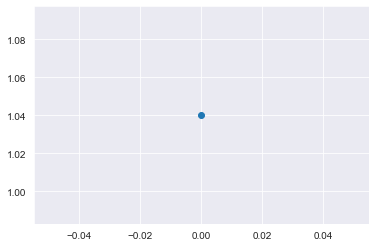

In [78]:
plt.scatter(epochs, avg_losses)

## Test data

In [79]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

MyRNN(
  (rnn): RNN(2, 1, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1, out_features=1, bias=False)
  (final): Tanh()
)

In [80]:
test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [81]:
losses = []
outputs = []
elos = []
for evals, elo in test_data_loader:
    #print("evals",evals.shape)
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
    loss = criterion(output,elo)
    #print(f'Model prediction : {output} \n ELO : {elo} \n MSE : {loss}')
    losses.append(loss.item())
print(f'Average loss : {stats.mean(losses)}')

Average loss : 1.4130225465482438


In [82]:
model(evals)

tensor([-0.5956], grad_fn=<SelectBackward0>)

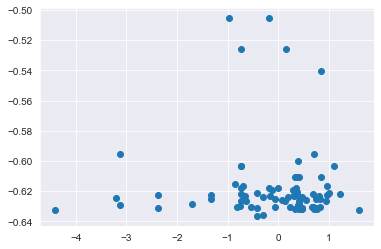

In [83]:
plt.scatter(elos,outputs, alpha = 1)

# Plotting the neural net architecture

In [84]:
model =model.eval()

In [85]:
# note - to use any of these, I'm not sure that I can use the packed sequence. I would have to change the way the NN works, a little bit
tb = SummaryWriter()

In [86]:
print(max(outputs))
print(min(outputs))

-0.5054596662521362
-0.6363077163696289


In [87]:
# Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
#traced_script_module = torch.jit.trace(model, example)

In [88]:
model.named_parameters()

<generator object Module.named_parameters at 0x00000212916DFDF0>

In [89]:
dict(model.named_parameters())

{'rnn.weight_ih_l0': Parameter containing:
 tensor([[0.9115, 0.9103]], requires_grad=True),
 'rnn.weight_hh_l0': Parameter containing:
 tensor([[-0.4849]], requires_grad=True),
 'rnn.bias_ih_l0': Parameter containing:
 tensor([-0.2168], requires_grad=True),
 'rnn.bias_hh_l0': Parameter containing:
 tensor([-0.3908], requires_grad=True),
 'rnn.weight_ih_l1': Parameter containing:
 tensor([[-0.7730]], requires_grad=True),
 'rnn.weight_hh_l1': Parameter containing:
 tensor([[0.4432]], requires_grad=True),
 'rnn.bias_ih_l1': Parameter containing:
 tensor([0.9398], requires_grad=True),
 'rnn.bias_hh_l1': Parameter containing:
 tensor([0.3988], requires_grad=True),
 'fc.weight': Parameter containing:
 tensor([[-0.7705]], requires_grad=True)}

In [90]:
dot = make_dot(output.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [91]:
#ot = graphviz.Digraph('dot', graph_attr={'nslimit': '0','nslimit1': '2'},node_attr={'shape': 'plaintext'})

In [92]:
# dot = graphviz.Digraph('dot',format="png",
#               engine='neato', # Layout engine.
#               graph_attr=dict(splines='true',
#                               sep='5',
#                               overlap='scale'),
#               node_attr=dict(shape='circle',
#                              margin='0',
#                              fontsize='10',
#                              width='0.2',
#                              height='0.2',
#                              fixedsize='true'),
#               edge_attr=dict(arrowsize='0.4'))

In [93]:
dot.render("rnn_torchviz3", format="pdf", engine= 'neato')

'rnn_torchviz2.pdf'